# Exercise 1: Predicting the temperature

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [53]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [54]:
# Y is the target variable
Y = weather_df['temperature']

# X is the feature set
X = weather_df[['humidity','windspeed', 'windbearing', 'pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

predictions = lrm.predict(X)
errors = np.array(Y) - predictions

# Estimated coefficients.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528471


### Assumption two: the error term should be zero on average

In [55]:
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -5.563350793091222e-15


Since the mean is very close to zero, we can assume that the average of the error terms is zero.

### Assumption three: homoscedasticity

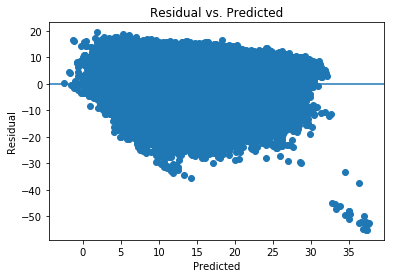

In [56]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [57]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


Both the chart and the test results show us that there is heteroscedasticity problem in our model. Hence, the accuracies of our estimated parameters are not reliable.

### Assumption four: low multicollinearity

In [58]:
X.corr()

humidity  windspeed  windbearing  pressure
humidity     1.000000  -0.224951     0.000735  0.005454
windspeed   -0.224951   1.000000     0.103822 -0.049263
windbearing  0.000735   0.103822     1.000000 -0.011651
pressure     0.005454  -0.049263    -0.011651  1.000000

As the table above suggests, the correlation between the features are very low. The mostly correlated variables are windspeed and humidity and the correlation is just -0.22.

### Assumption five: error terms should be uncorrelated with one other

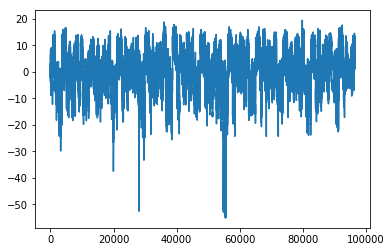

In [59]:
plt.plot(errors)
plt.show()

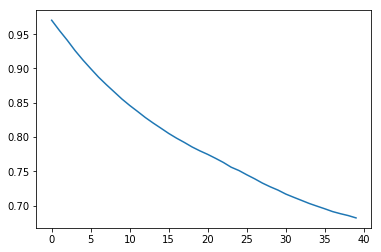

In [60]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

It seems that the errors are serially correlated. This is because of the time series nature of the data. The weather from the previous day is highly correlated with the weather today. Our model can't explain the temperature very well and hence it suffers from the omitted variable. However, since the dataset involves very limited number of features, fixing this issue is not trivial.

### Assumption six: features shouldn't be correlated with the errors

In [61]:
df = pd.concat([X, pd.DataFrame(errors, columns=["error"])], axis=1)
df.corr().iloc[:,-1:]

error
humidity    -2.503115e-14
windspeed    6.447441e-15
windbearing  2.019223e-16
pressure    -1.009730e-15
error        1.000000e+00

As evidenced above, the correlation between the features and the errors are very low.

### An important remark on the normality of the errors

In [9]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252227 and p value is 0.0
Normality test statistics is 3375.4323076994956 and p value is 0.0


Normality tests indicate that the errors of the model are not distributed normally. This implies that the test statistics for the coefficients are problematic.

# Exercise 2: House prices

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [63]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [64]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

In [87]:
# Y is the target variable
Y = house_prices_df['saleprice']
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

predictions = lrm.predict(X)
errors = np.array(Y) - predictions

# Estimated coefficients.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [21636.11831431    47.61074511  5502.16876014    38.7830869
    39.92749303 29974.2662167  14960.22006443 30152.46873247
 12975.53397893  2242.02609805]

Intercept: 
 -122951.85479583053


### Assumption two: the error term should be zero on average

In [88]:
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: 5.284326850466092e-12


The average error is quite close to zero so we can assume that it is zero.

### Assumption three: homoscedasticity

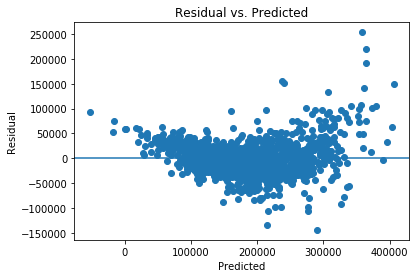

In [89]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [90]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 723.465 and p value is 2.36e-159
Levene test statistic value is 628.583 and p value is 9.5e-126


Both the chart and the test statistics indicate that our model suffers from heteroscedasticity. This implies that the accuracies of our estimations are not reliable.

### Assumption four: low multicollinearity

In [91]:
X.corr()

overallqual  grlivarea  garagecars  garagearea  totalbsmtsf  \
overallqual     1.000000   0.579911    0.597097    0.553099     0.530136   
grlivarea       0.579911   1.000000    0.471052    0.451268     0.390054   
garagecars      0.597097   0.471052    1.000000    0.886455     0.446384   
garagearea      0.553099   0.451268    0.886455    1.000000     0.469909   
totalbsmtsf     0.530136   0.390054    0.446384    0.469909     1.000000   
mszoning_FV     0.176721   0.031113    0.104627    0.118175    -0.030831   
mszoning_RH    -0.064477   0.001352   -0.090286   -0.073115    -0.056900   
mszoning_RL     0.123303   0.130104    0.173028    0.167051     0.265277   
mszoning_RM    -0.193923  -0.155248   -0.220488   -0.234706    -0.256428   
street_Pave     0.058991   0.045713   -0.020500   -0.048940     0.004195   

             mszoning_FV  mszoning_RH  mszoning_RL  mszoning_RM  street_Pave  
overallqual     0.176721    -0.064477     0.123303    -0.193923     0.058991  
grlivarea       0.031113     0.001352     0.130104    -0.155248     0.045713  
garagecars      0.104627    -0.090286     0.173028    -0.220488    -0.020500  
garagearea      0.118175    -0.073115     0.167051    -0.234706    -0.048940  
totalbsmtsf    -0.030831    -0.056900     0.265277    -0.256428     0.004195  
mszoning_FV     1.000000    -0.022818    -0.416418    -0.090850     0.013925  
mszoning_RH    -0.022818     1.000000    -0.203050    -0.044300     0.006790  
mszoning_RL    -0.416418    -0.203050     1.000000    -0.808430     0.045236  
mszoning_RM    -0.090850    -0.044300    -0.808430     1.000000    -0.003018  
street_Pave     0.013925     0.006790     0.045236    -0.003018     1.000000

We have some highly correlated features like *garagearea* and *garagecars*. We can solve this issue by dropping one of the strongly correlated variables from the model.

### Assumption five: error terms should be uncorrelated with one other

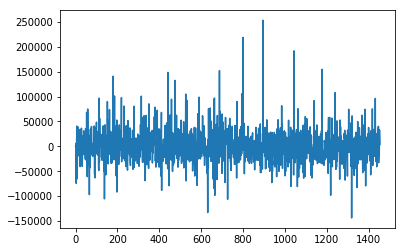

In [92]:
plt.plot(errors)
plt.show()

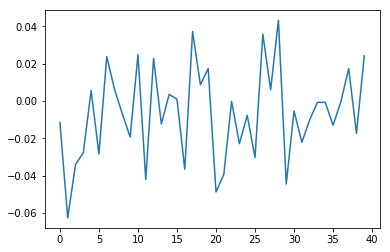

In [93]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The charts above indicate that the error terms are uncorrelated with each other.

### Assumption six: features shouldn't be correlated with the errors

In [94]:
df = pd.concat([X, pd.DataFrame(errors, columns=["error"])], axis=1)
df.corr().iloc[:,-1:]

error
overallqual  0.019523
grlivarea    0.046022
garagecars   0.051089
garagearea   0.049024
totalbsmtsf -0.007251
mszoning_FV  0.021536
mszoning_RH -0.003766
mszoning_RL -0.020791
mszoning_RM  0.019275
street_Pave -0.000214
error        1.000000

As evidenced in the table above, the features and the errors are not **linearly** correlated.

### An important remark on the normality of the errors

In [95]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 2843.9980035501744 and p value is 0.0
Normality test statistics is 385.02559105244535 and p value is 2.4703313347752903e-84


Normality tests indicate that the errors of the model are not distributed normally. This implies that the test statistics for the coefficients are problematic.